Oracle Data Science service sample notebook.

Copyright (c) 2021-2022 Oracle, Inc.<br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font> Predicting Employee Attrition with ADS</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

***

## Overview:

This notebook uses an employee attrition dataset. It is a synthetic dataset that contains information about employees and if they have left the company or not. To understand the data, you start by doing an exploratory data analysis (EDA). This is followed by creating a model using `scikit-learn`. The model is used to make predictions and evaluate the model's performance on new data. Then the model is prepared and saved to the Model Catalog using Oracle's Accelerated Data Science, (`ADS`) library.

***

**<font color='red'>NOTE: This notebook was run in the PySpark 3.0 and Data Flow (slug: `pyspark30_p37_cpu_v5`) conda environment.</font>**

***

<font color=gray>Datasets are provided as a convenience.  Datasets are considered Third Party Content and are not considered Materials under Your agreement with Oracle applicable to the Services.  You can access the `orcl_attrition` dataset license [here](oracle_data/UPL.txt). Dataset `orcl_attrition` is distributed under UPL license. 
</font>

In [1]:
import ads
import io
import joblib 
import logging
import numpy as np  
import os
import pandas as pd
import sys 
import warnings

from ads.common.model import ADSModel
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads.dataset.factory import DatasetFactory
from ads.dataset.label_encoder import DataFrameLabelEncoder
from ads.evaluations.evaluator import ADSEvaluator
from collections import defaultdict
from os import path 
from os.path import expanduser
from os.path import join
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer

ads.set_auth(auth='resource_principal') 

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

<a id='binaryclassifition'></a>
# Binary Classification

Binary classification is a technique of classifying observations into one of two categories. In this notebook, the two groups are those employees that will leave the organization and those that will not.

Given the features in the data, the model will determine the optimal criteria for classifying an observation as leaving or not leaving. This optimization is based on the training data. However, some data will be excluded from the training data so that the model's performance can be evaluated. Models can over-fit on the training data, that is learn the noise in a dataset. Models can also under-fit the data, meaning that it does not learn the important characteristics of the relationships between the predictors and the target variable. Further, the model learns from the training data but its predictive power on the training data is not a good measure of the model's performance. Therefore, a test set of data is withheld from the full data set so that model's performance on an unseen set of data can be evaluated.

The evaluation will be done using classic measures for fit for binary classification. These would be metrics such as specificity, sensitivity, accuracy, area under the ROC curve, lift, gain, and several others.

# Open and Visualize the Dataset using `ADS`

<a id='data'></a>
## Dataset

This is a synthetic data set which contains 1,470 observations. There are 36 features, where 22 are ordinal, 11 are categorical, and 3 are constant values. The data contains demographic information, compensation level, job characteristics, job satisfaction, and employee performance. The data is imbalanced as fewer employees leave than stay.

The first step is to load the dataset. To do this the `DatasetFactory` singleton object will be used. It is part of the `ADS` SDK. It is a powerful class to work with datasets from different sources as you can store metadata such as what column is the target and what type of modeling problem is trying to be solved. In this case, it is a binary classification problem.

In [2]:
employees = DatasetFactory.open("/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv", 
                                target="Attrition").set_positive_class('Yes')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

<a id='viz'></a>
## Visualize the Dataset

The `.show_in_notebook()` method provides reasonable EDA information about each feature. It provides:

- Summary: This shows a brief description of the dataset, shape, and a breakdown by feature type.
- Features: Contains a table that provides summary information about each feature along with metrics from its distribution. It also contains a summary plot based on the type of data and summary metrics.
- Correlations: Heatmaps showing the correlation between different features. There are three maps, each one showing the relationship between different types of data (i.e. interval and categorical)
- Warnings: An analysis of each feature is performed to check for data conditions that may affect your model's performance.

In [3]:
employees.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,470 Rows, 36 Columns</h3><h4>C…

<a id='trans'></a>
# Transformation Recommendations

`ADS` can help with feature engineering by automatically transforming datasets. For example, it can fix class imbalance by up or downsampling. This is just one example of the many transforms that `ADS` can apply. You can have `ADS` perform an analysis of the data and automatically apply the appropriate transformations to improve a model's performance. This is done with the `.auto_transform()` method. The `.suggest_recommendations()` method allows you to explore the suggested transforms using the notebook's UI and select the transformations that you would like it to make.

All ADS datasets are immutable; any transforms that are applied result in a new dataset. In this example, the notebook will perform automatic transformations on the data, and it will also fix the class imbalance.

In [4]:
transformed_ds = employees.auto_transform(fix_imbalance=True)

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

The data should be split into training and test sets. This can be done using the `.train_test_split()`. The following cell uses the parameter `test_size` to indicate that it wants 80% of the data to be allocated to the training set and the remaining 20% will go to the test set.

In [5]:
train, test = transformed_ds.train_test_split(test_size=0.8)

# Training a Random Forest Model 

The next cell trains a Randow Forest model. It use the sklearn `Pipeline()` object to assemble the data transformations and model estimators into a single object. 

In [6]:
X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X = le.fit_transform(X)

sk_clf = RandomForestClassifier(random_state=42)
sk_clf.fit(X, y)

sk_model = make_pipeline(le, sk_clf)

# Build an ads model from the SVM classifier
my_model = ADSModel.from_estimator(sk_model, name=sk_clf.__class__.__name__)

<a id='eval'></a>
# Evaluate the Model

One of the key advantages of `ADS` is the ability to quickly evaluate any regression or classification model. While `ADS` has many built-in evaluation techniques, it supports the ability to provide your own evaluation function. You would provide a series of the true dependent variable value and another series of the predicted value. Then any esoteric calculation can be performed. This notebook uses the built-in performance metrics as these are sufficient for binary classification model evaluation.

The next cell creates the plots that are commonly used to evaluate model performance. These include the precision, recall, ROC, lift, and gain plots. Each model under study is plotted together, allowing for easy comparison. In addition, the normalized confusion matrices are provided.

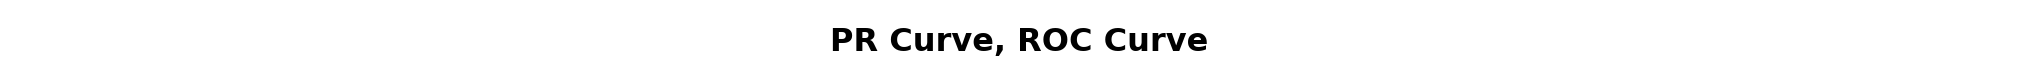

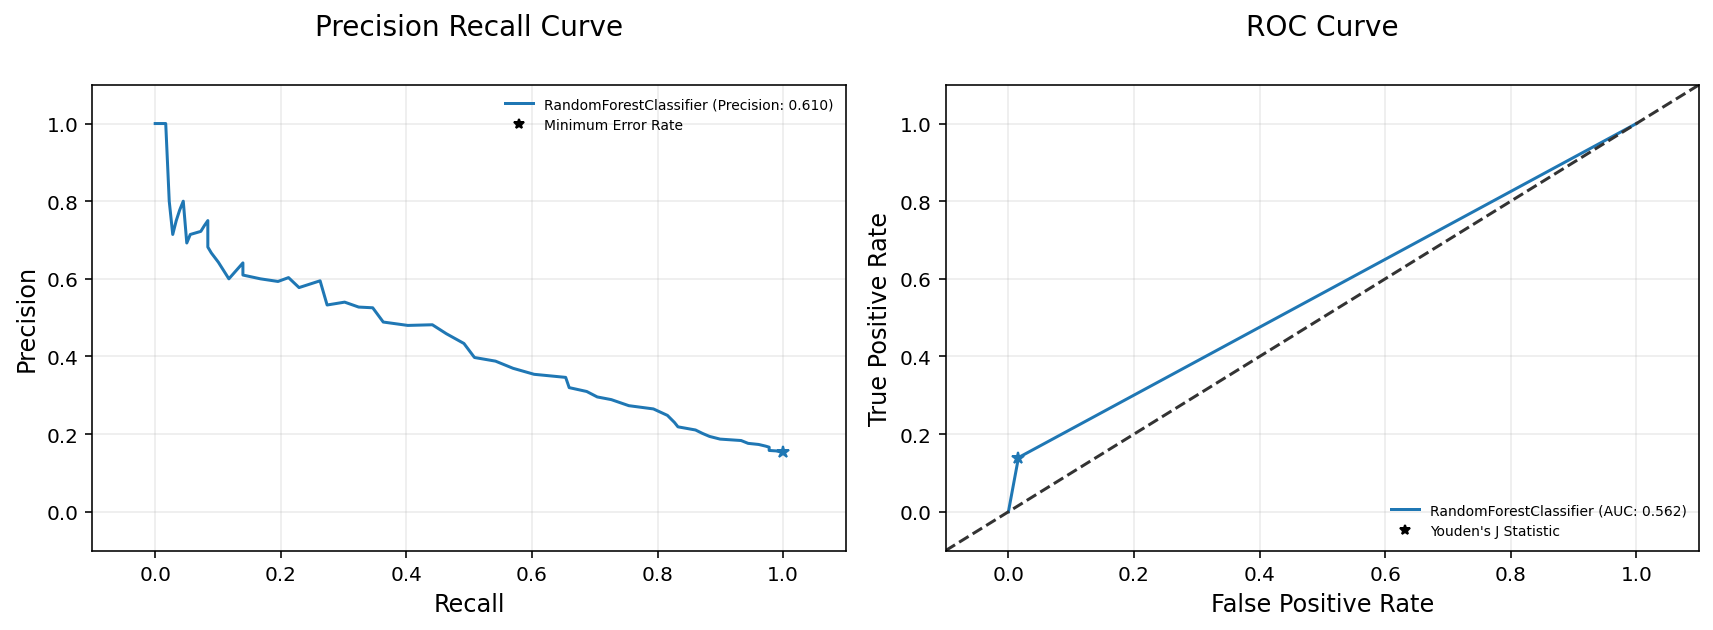

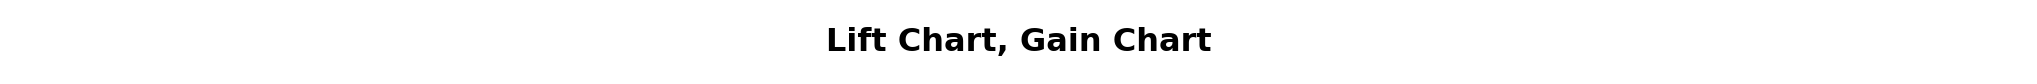

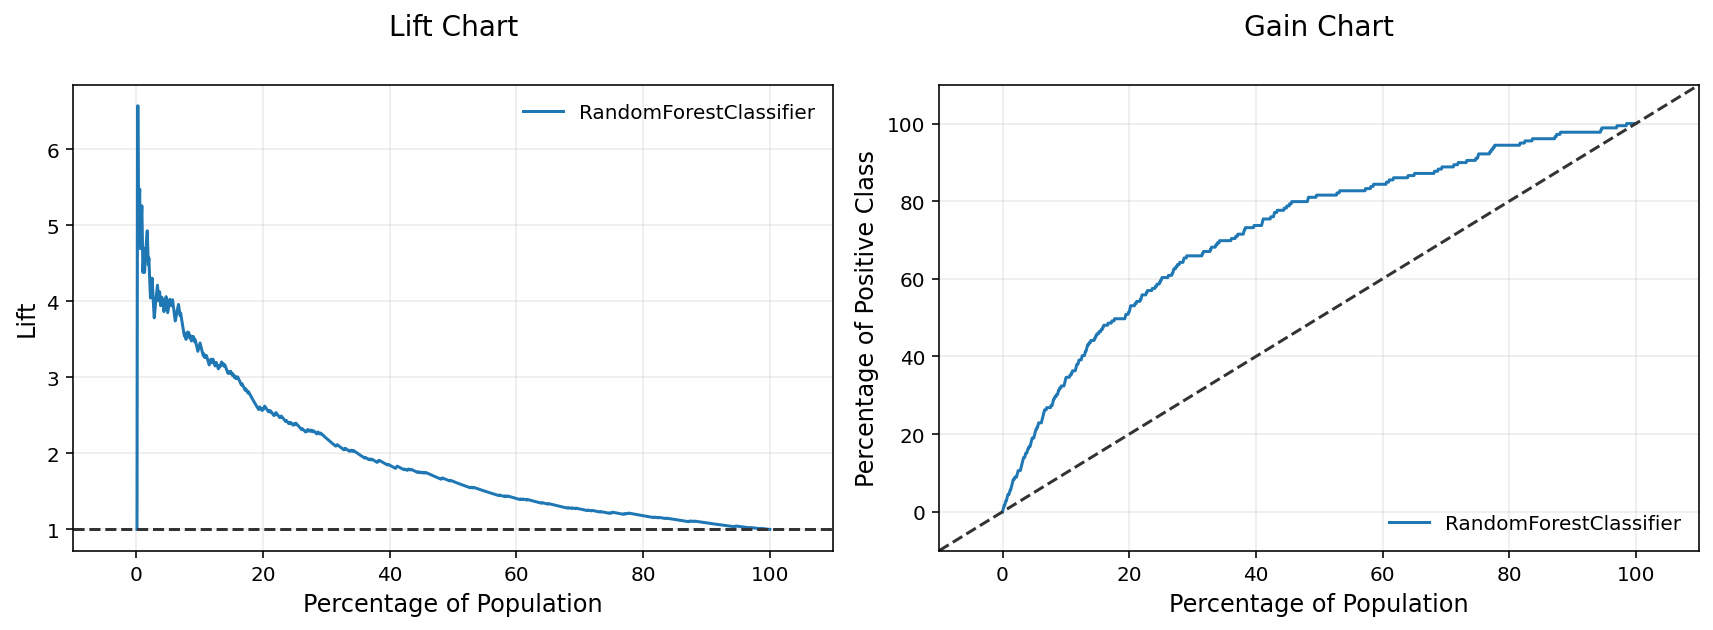

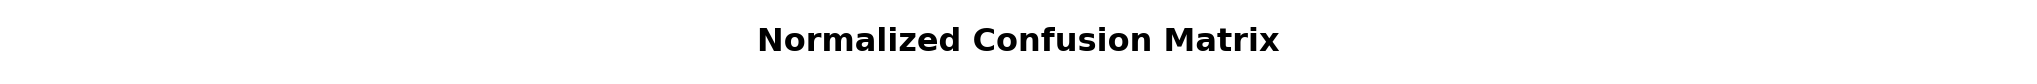

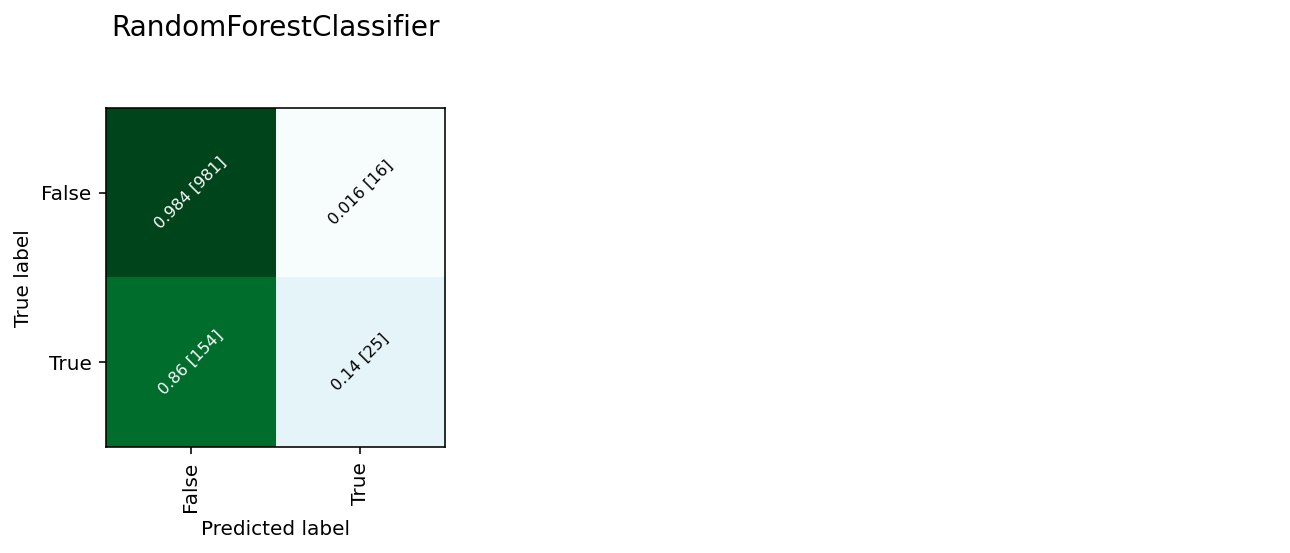

In [7]:
evaluator = ADSEvaluator(test, models=[my_model], 
                         training_data=train)
evaluator.show_in_notebook()

These metrics suggest that the model is not much better than chance. There is obviously a lot of work that would need to be done to improve the model's overall performance.

There are a number of common metrics that are used to assess the quality of a model. `ADS` provides a convenient method to compare the models and highlights the model with the highest score in each metric. The following cell computes the metrics using the test and training datasets. It demonstrates that the model is a perfect classifier of the training data. It also demonstrates that on the test data, the model has a lot of room for improvement. The significant difference between the training and test metrics is a strong indication that the model is overfitting.

The goal of this exercise is to create a model, not an ideal model. Therefore, the next step is to prepare the model for productionalization.

In [8]:
evaluator.metrics

HTML(value='<style type="text/css">\n#T_70a86_row0_col0, #T_70a86_row1_col0, #T_70a86_row2_col0, #T_70a86_row3…

HTML(value='<style type="text/css">\n#T_16d73_row0_col0, #T_16d73_row1_col0, #T_16d73_row2_col0, #T_16d73_row3…

A binary classification model can have one of four outcomes for each prediction. A true-negative is an outcome where the model correctly predicts the negative case, and a false-negative is an outcome where when the model incorrectly predicts the negative case. A false-positive is when the model incorrectly predicts the positive case, and a true-positive is when the model correctly predicts the positive case. However, not all false-positive and false-negatives have the same importance. For example, a cancer test has a higher cost when it incorrectly says that a patient does not have cancer when they do. The `.calculate_cost()` method allows the cost to be computed for each model based on the cost of each class of prediction.

In [9]:
evaluator.calculate_cost(tn_weight=1, fp_weight=3, fn_weight=2, tp_weight=2)

,model,cost
0,RandomForestClassifier,1387


# Prepare Model Artifacts

The next cell prepares the model so that it can be saved in the model catalog. The `.prepare_generic_model()` method creates the artifacts that are packaged up and eventually saved to the Model Catalog. This method creates editable template artifacts. An important file is `score.py`. It has a method `load_model()` that is used to load the model that will be used for inference. It also has a method `predict()` that accepts JSON data that is used in performing the predictions. This example is using a sklearn model but the design is flexible enough that almost any model class can be used.

## Create Artifacts

In the following cell, the `inference_conda_env` value is specified. This parameter corresponds to the conda environment that is used in the model deployment. A reference of that environment is written to `runtime.yaml`. The path represents where the conda environment is stored in Object Storage. You can find that information in the Environment Explorer.

In [10]:
# Path to artifact directory for my sklearn model: 
model_artifact_location = os.path.expanduser('./model-artifact/')
os.makedirs(model_artifact_location, exist_ok=True)

# Creating a joblib pickle object of my random forest model: 
joblib.dump(sk_model, os.path.join(model_artifact_location, "model.joblib"))

# Creating the artifact template files in the directory: 
artifact = prepare_generic_model(
    model_artifact_location, 
    inference_conda_env="oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/PySpark_3.0_and_Data_Flow/5.0/pyspark30_p37_cpu_v5",
    force_overwrite=True,
    model='model.joblib',
    use_case_type='BINARY_CLASSIFICATION',
    X_sample=train.X,
    y_sample=train.y)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

## Update `score.py`

The `.prepare_generic_model()` method creates a templated `score.py` file that is used to load the model and and make inferences. The following cell, makes some minor changes such as ensuring that the `.load_model()` method reads in the `model.joblib` file.

In [11]:
score_path = os.path.join(model_artifact_location, "score.py")

In [12]:
%%writefile {score_path}

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

import io 
import json
import logging 
import os
import pandas as pd

from ads.dataset.label_encoder import DataFrameLabelEncoder
from joblib import load

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "model.joblib"
    
    # Load a model file
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
  
    return { 'prediction': preds }

Overwriting ./model-artifact/score.py


## Test Artifact

It is a good idea to test the model artifact before saving it to the Model Catalog. The next cell loads the `score.py` module to gain access to the `load_model()` and `predict()` function. The Random Forest model is loaded and predictions are made. If the model can be loaded and predictions can be made, this is a good indication that the model will execute when it is put into production.

In [13]:
# add the path of score.py: 
sys.path.insert(0, model_artifact_location)
from score import load_model, predict

# Load the model to memory 
_ = load_model()

# make predictions on the first five rows of the training dataset: 
input_data = test.X[:5]
predictions = predict(input_data.to_json()) 

print(predictions)

{'prediction': [False, False, False, False, False]}


# Save to the Model Catalog

The `.save()` method is used to save the model artifacts and their metadata to the Model Catalog. When saving the model include information such as what project and compartment should be used. It is helpful to include a display name so that the model can be identified in the console, along with a description. The training script path is the path of this notebook, this way you will know how to model was generated. If the notebook is under git revision control, the `.save()` method will also capture what version of the notebook was used.

In [14]:
mc_model = artifact.save(
    project_id=os.environ['PROJECT_OCID'], 
    compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'], 
    training_id=os.environ['NB_SESSION_OCID'],
    display_name="attrition-model",
    ignore_introspection=False,
    description="Model to predict employee attrition", 
    training_script_path="1-model-training.ipynb", 
    ignore_pending_changes=True)

['input_schema.json', 'runtime.yaml', 'test_json_output.json', 'score.py', 'model.joblib', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_14c3c246-8254-46f3-b400-9e4cb85d10e3.zip


The model is in the Model Catalog and it has a unique OCID. Save this OCID as it is needed in a future section of this course.

In [15]:
print(mc_model.id)

ocid1.datasciencemodel.oc1.iad.amaaaaaajb4jzaiau6tfegywe4tlwquuyj6cbuhvzr5of7rssovt5eyoglia
